# Get required inputs
We build the design matrix and contrast (used to get the F threshold later), and load the F-statistic map. 

In [1]:
import glob
import re
import pandas as pd
import numpy as np
import nibabel as nib

questionnaire_avg_out = "/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/output_surveyMedley_noderivs_rerun/questionnaire_averages"
bold_files = glob.glob(f"{questionnaire_avg_out}/*")
sub_ids = sorted(set([re.search('_sub_(.*).nii.gz', val).group(1) for val in bold_files]))

questionnaires_list = ["grit", "brief", "future_time", "upps", "impulsive_venture"]
sorted_bold_files = []
for sub in sub_ids:
    for q in questionnaires_list:
        sorted_bold_files.append(f"{questionnaire_avg_out}/{q}_questionnaire_avg_sub_{sub}.nii.gz")

design_matrix = pd.DataFrame()
# First 4 columns are dummy regressors for questionnaires 2-5 (brief, future_time, upps, and impulsive_venture)
one_indices = []
for i in range(len(sub_ids)):
    one_indices.append(1 + len(questionnaires_list) * i)
for i in range(len(questionnaires_list) - 1):
    one_indices_updated = [x + i for x in one_indices]
    col = [1 if j in one_indices_updated else 0 for j in range(len(sorted_bold_files))]
    design_matrix[questionnaires_list[i + 1]] = col
# The other 66 columns are dummy regressors for each subject
one_indices = [0, 1, 2, 3, 4]
for i in range(len(sub_ids)):
    one_indices_updated = [x + len(questionnaires_list) * i for x in one_indices]
    col = [1 if j in one_indices_updated else 0 for j in range(len(sorted_bold_files))]
    design_matrix[sub_ids[i]] = col

contrast = np.zeros((4, 70)) 
contrast[:, 0:4] = np.eye(4)

f_stat_map = nib.load("/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/output_surveyMedley_noderivs_rerun/questionnaire_avgs_f_test_output/questionnaire_averages_f_test_f_stat.nii.gz")

# Get clusters and make a label map of above-threshold clusters

In [2]:
from scipy.stats import f
from nilearn.reporting import get_clusters_table

# Degrees of freedom
df_num = contrast.shape[0]
df_den = design_matrix.shape[0] - design_matrix.shape[1]

# F threshold for p = 0.0005 (right-tail)
f_p_0005 = f.isf(0.0005, df_num, df_den)

cluster_table, cluster_label_maps = get_clusters_table(
    stat_img=f_stat_map,
    stat_threshold=f_p_0005,   # F-stat threshold
    cluster_threshold=100,     # min cluster size in voxels (set >0 to filter)
    two_sided=False,            # F-tests are always positive
    min_distance=500,
    return_label_maps=True
)
cluster_table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-6.299998,-90.699999,-3.699998,62.181972,159922
1,2,-34.899999,34.700004,-10.299999,33.475270,47979
2,3,-17.299998,39.100004,51.300003,27.047872,37172
3,4,46.500003,10.500003,31.500002,20.841655,16397
4,5,31.100003,25.900003,-3.699998,16.479218,3215
5,6,-32.699999,-55.499998,7.300002,16.329500,1373
6,7,2.500002,-31.299998,-3.699998,15.535772,1064
7,8,26.700003,-40.099998,-12.499999,14.170489,8805
8,9,37.700003,-2.699997,46.900003,12.939243,4695
9,10,-52.499999,-75.299999,29.300002,12.063001,2363


# Plot figures

In [3]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn import plotting, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Step 1: Load cluster mask
cluster_img = cluster_label_maps[0]
cluster_data = cluster_img.get_fdata()
cluster_labels = np.unique(cluster_data)
cluster_labels = cluster_labels[cluster_labels != 0]  # exclude background

# Step 2: Extract subject IDs and questionnaire names
subject_ids = []
questionnaires = []
for fp in sorted_bold_files:
    # Extract subject ID between 'sub_' and '.nii.gz'
    sub_match = re.search(r"sub_([^/]+)\.nii\.gz", fp)
    subject_id = sub_match.group(1) if sub_match else "unknown"
    subject_ids.append(subject_id)

    # Extract questionnaire name before first '_questionnaire'
    base = os.path.basename(fp)
    q_match = re.match(r"(.*)_questionnaire", base)
    questionnaire = q_match.group(1) if q_match else "unknown"
    questionnaires.append(questionnaire)

subject_ids = np.array(subject_ids)
questionnaires = np.array(questionnaires)

# Step 3: Extract mean BOLD signals per cluster per file
masker = NiftiLabelsMasker(labels_img=cluster_img, standardize=False)
bold_by_cluster = masker.fit_transform(sorted_bold_files)
# shape: (n_files, n_clusters)

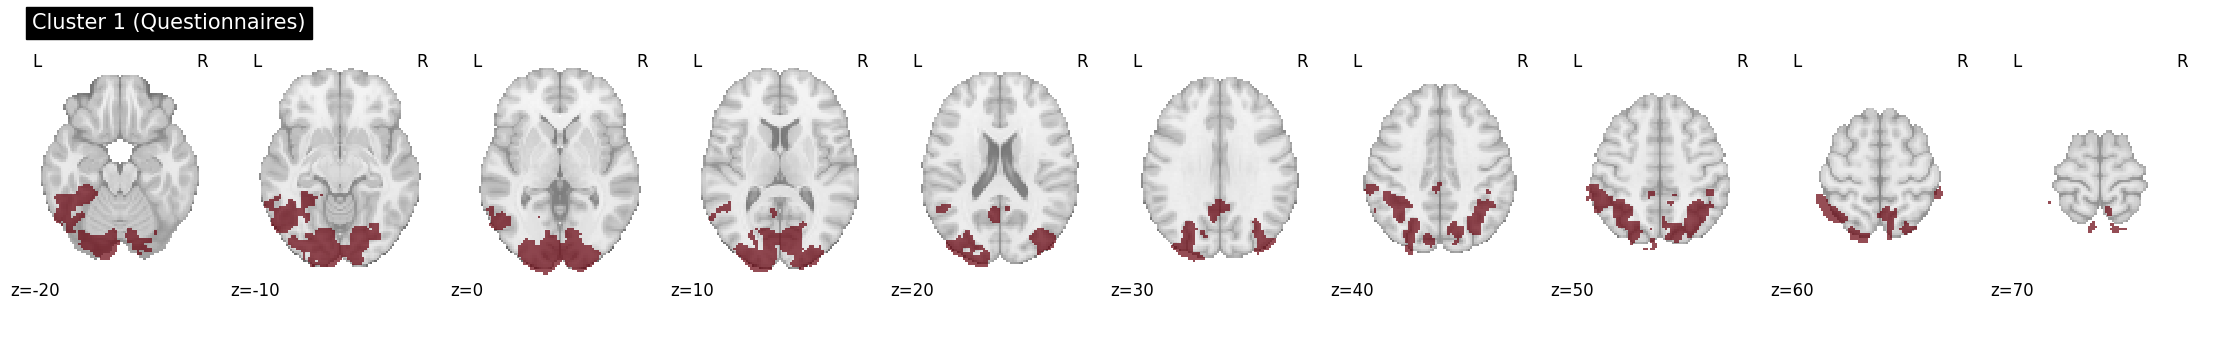

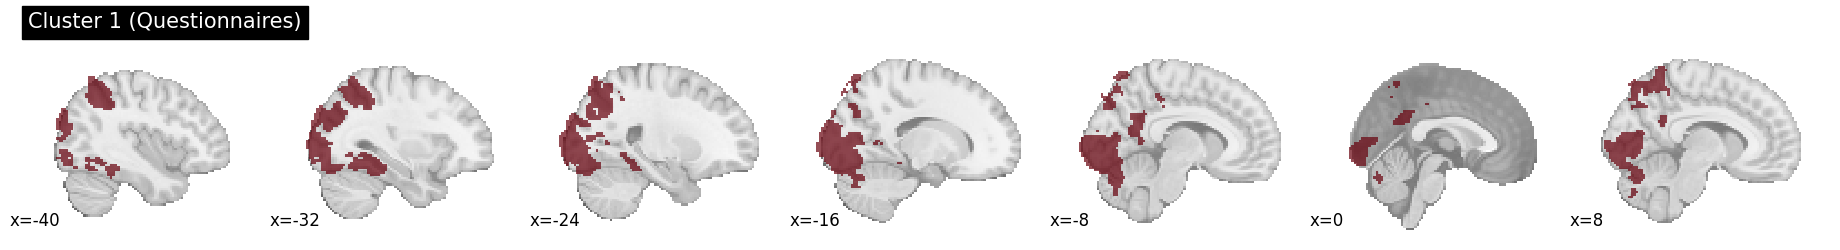

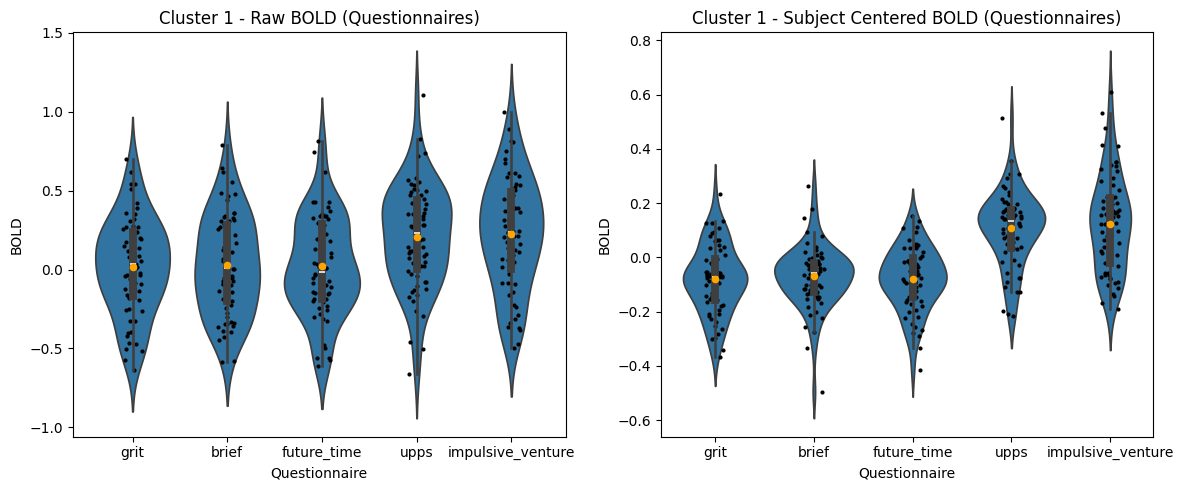

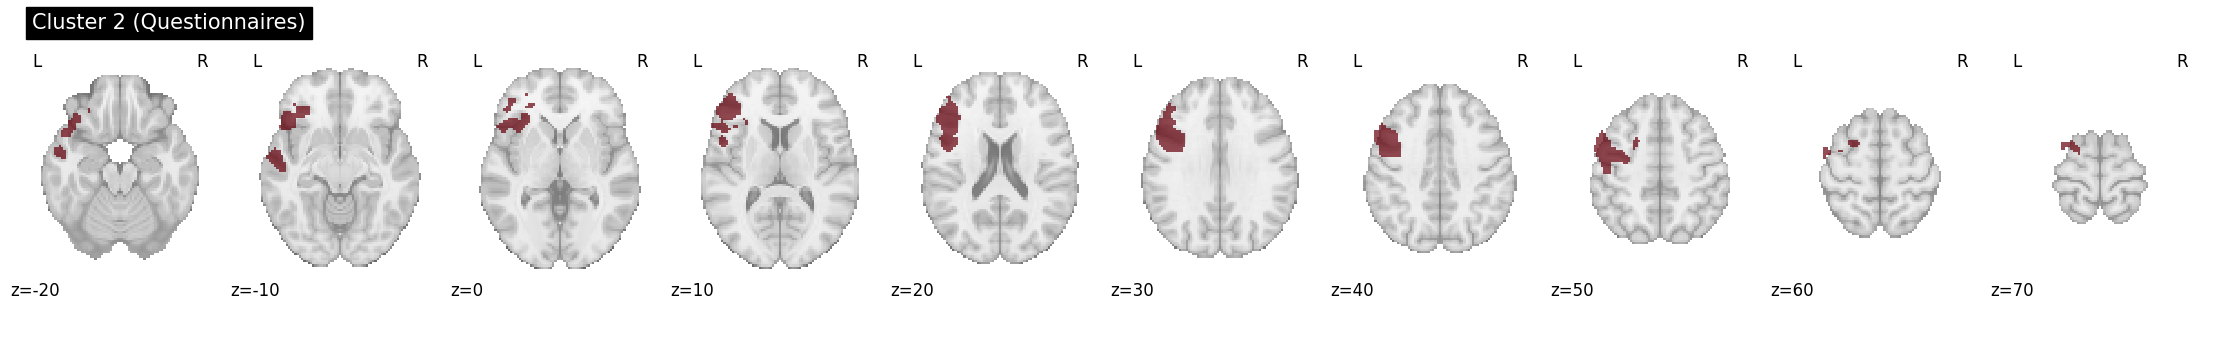

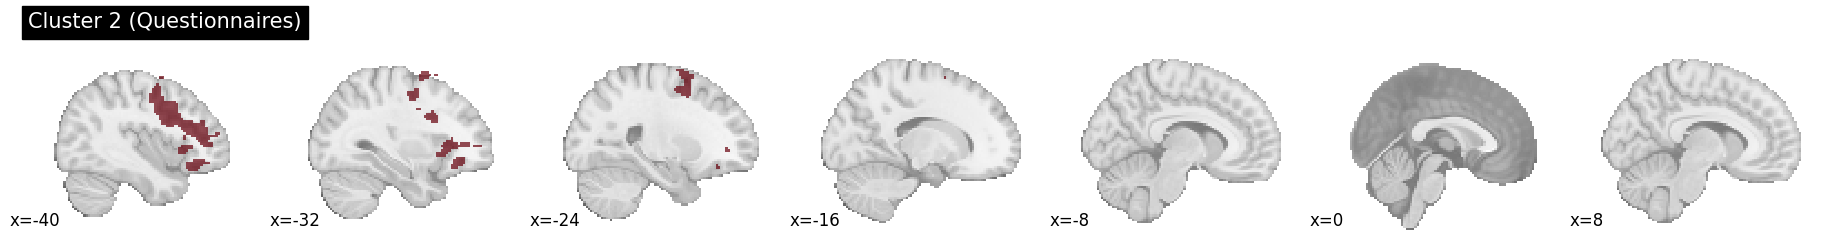

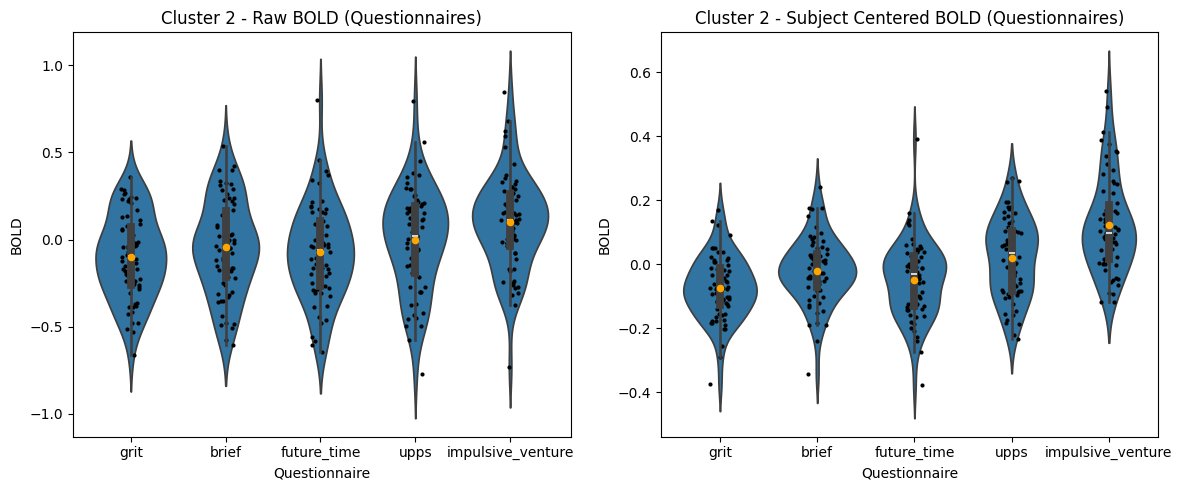

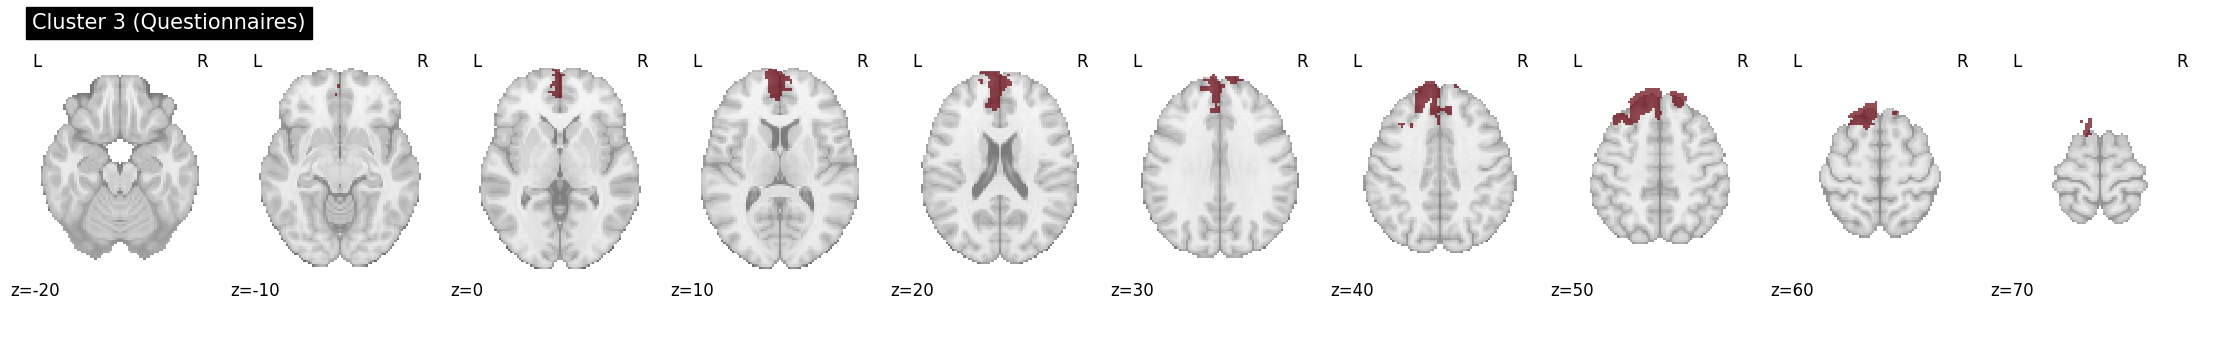

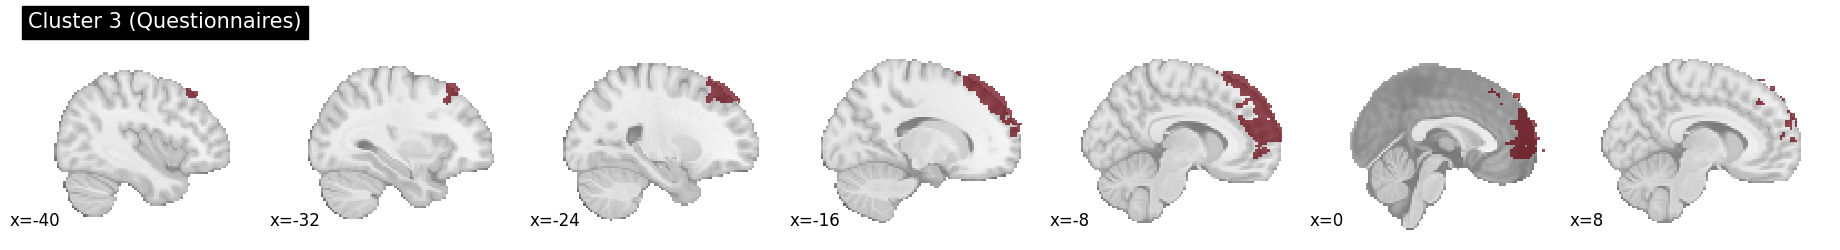

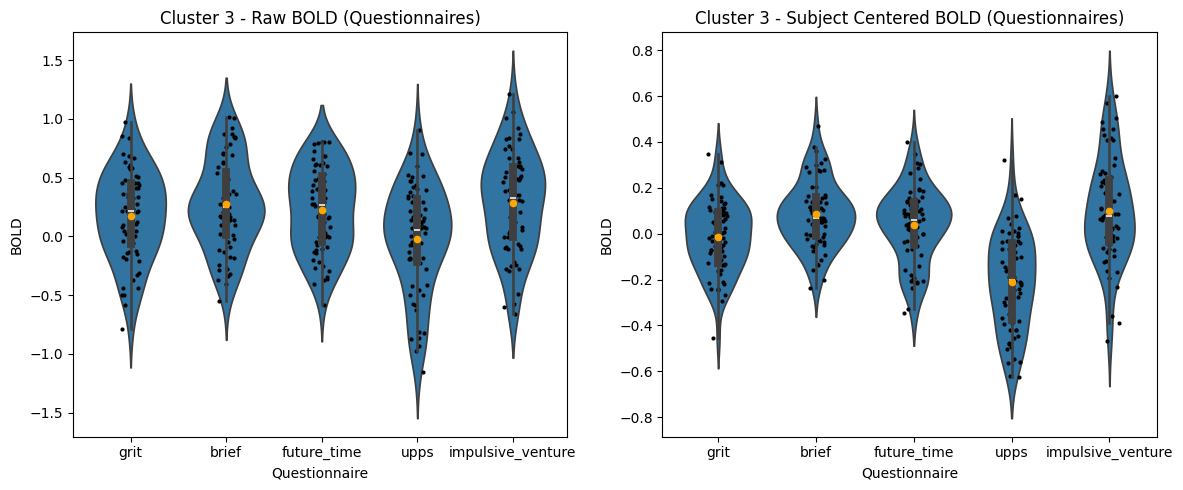

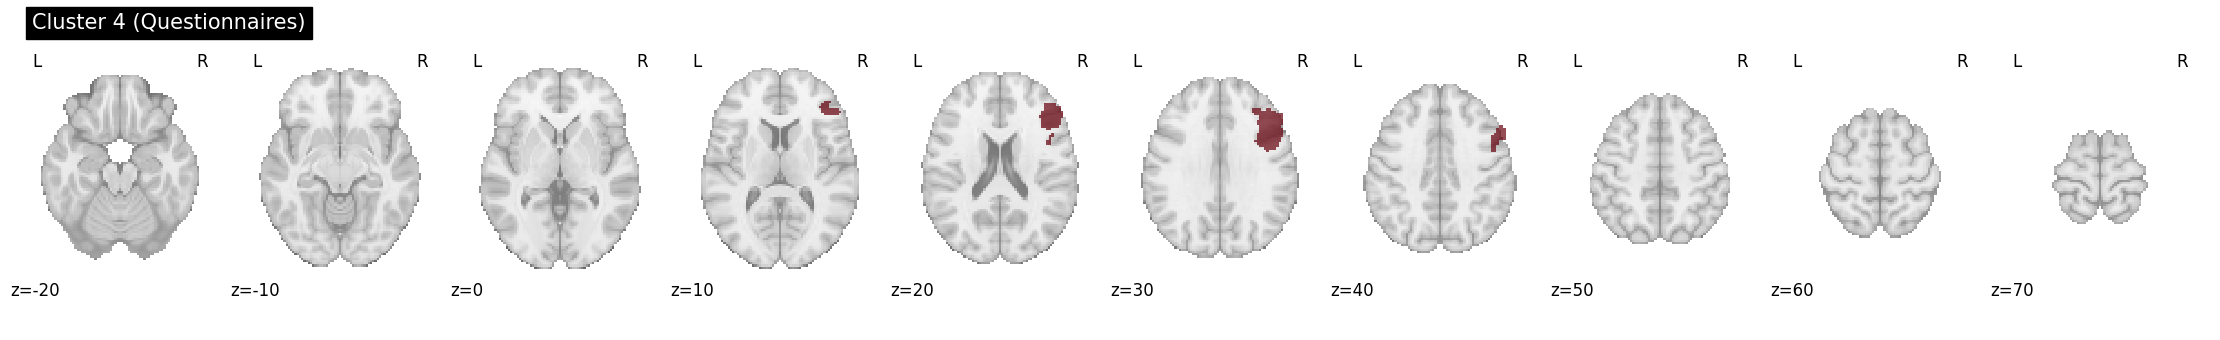

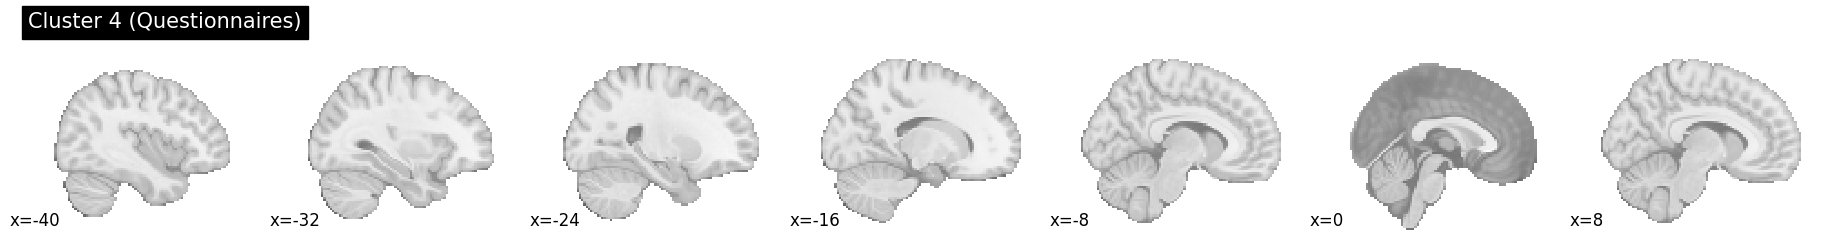

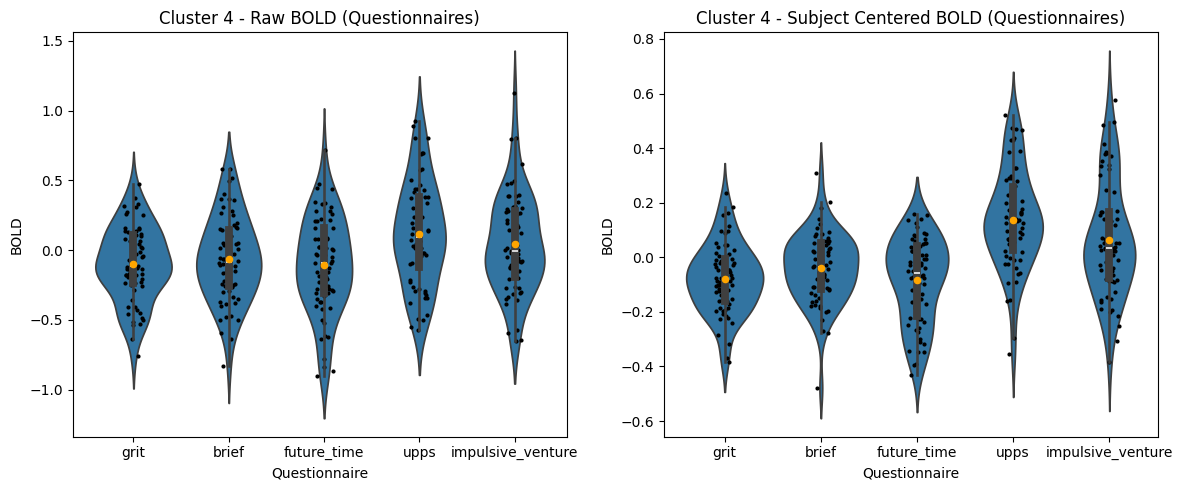

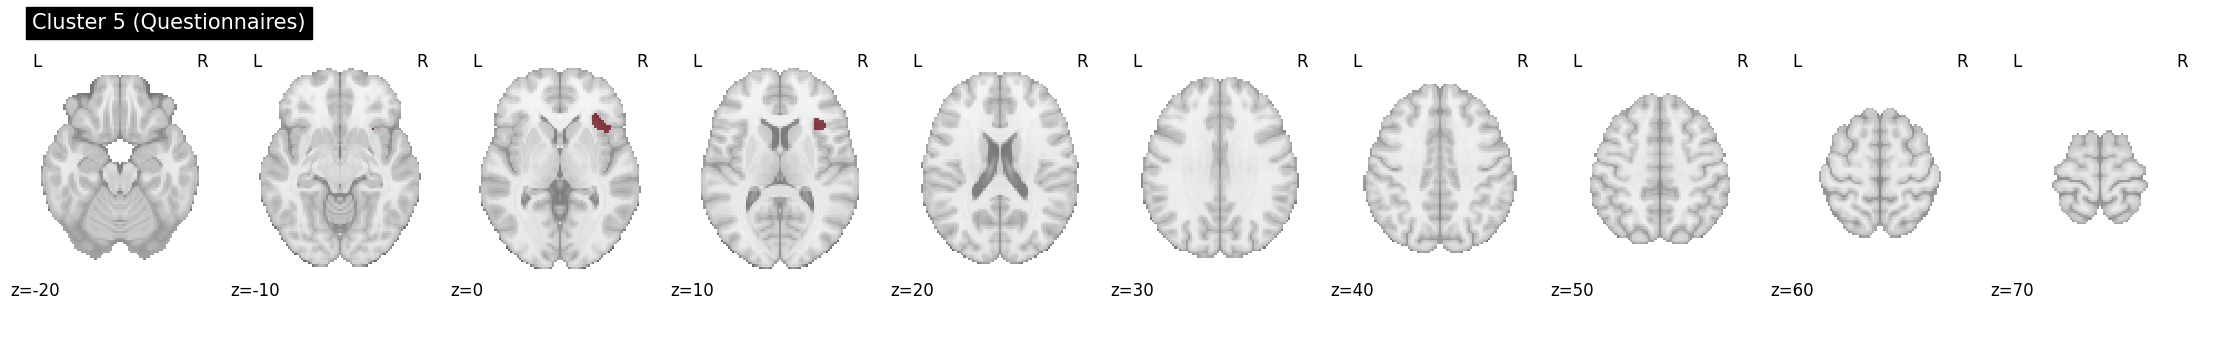

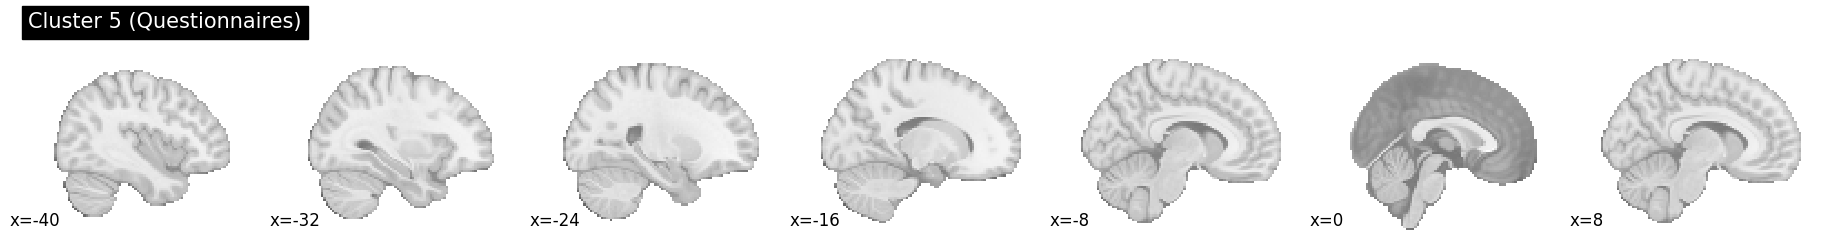

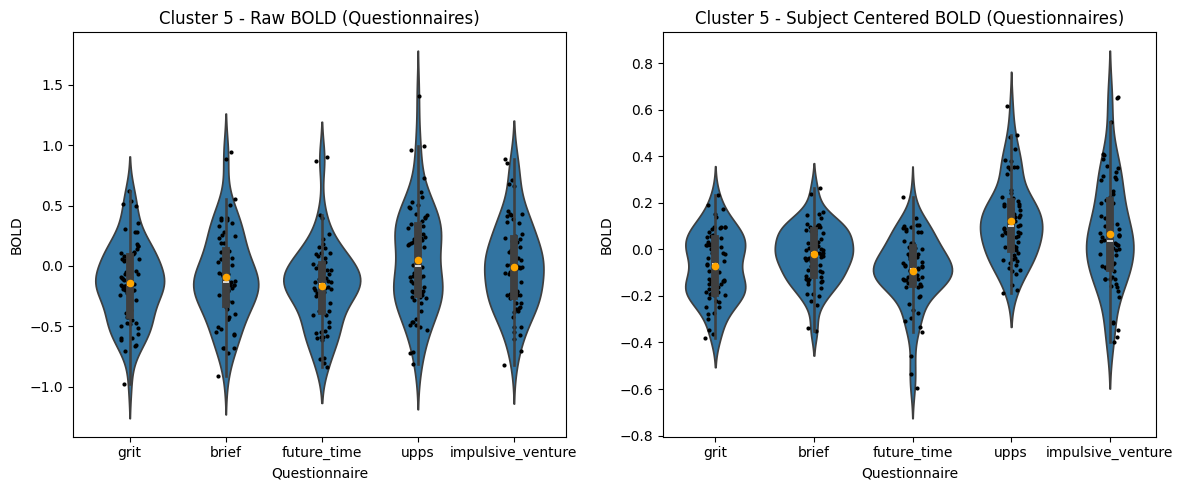

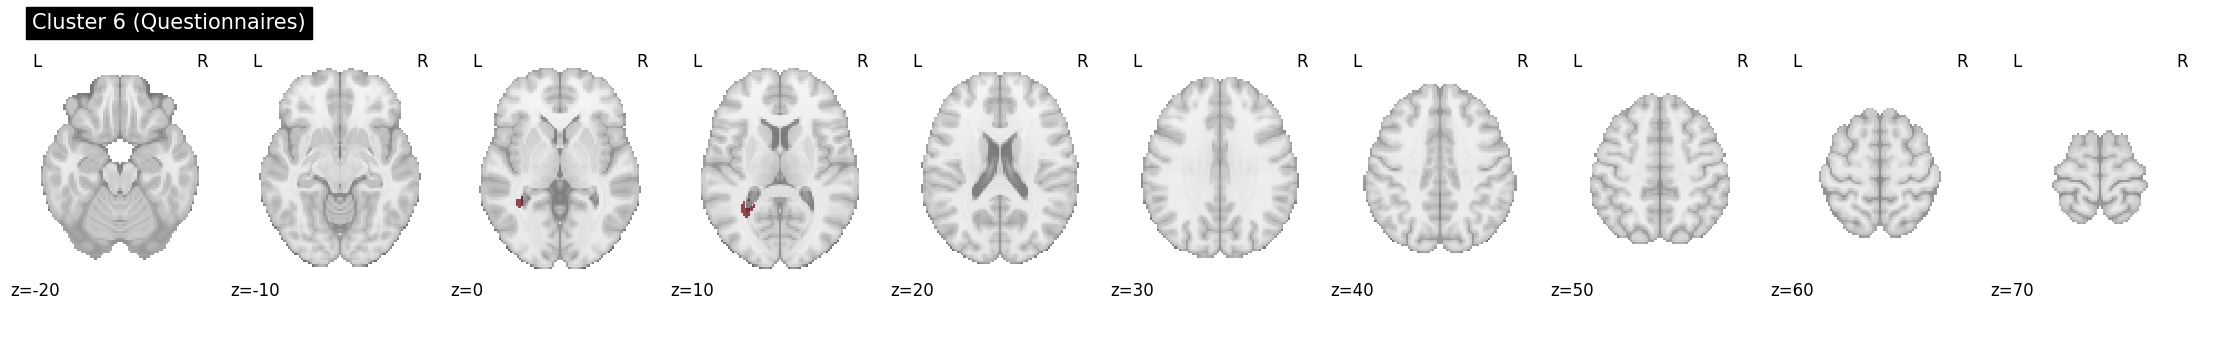

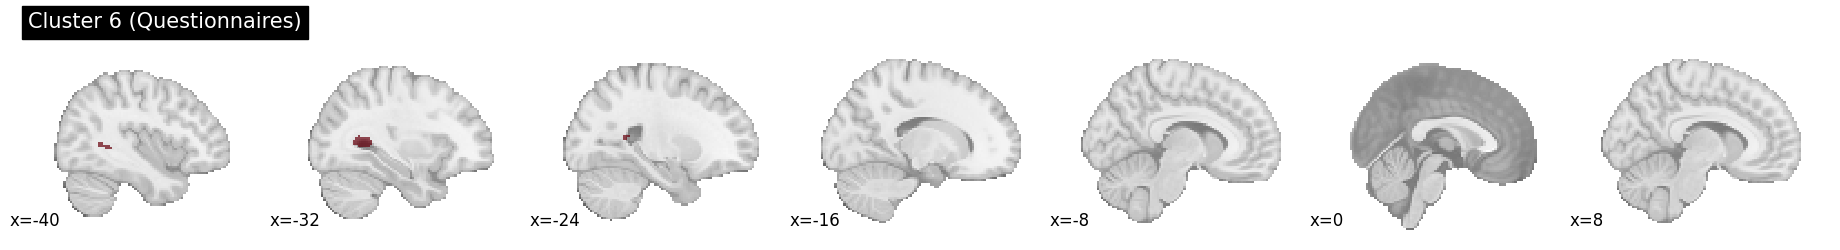

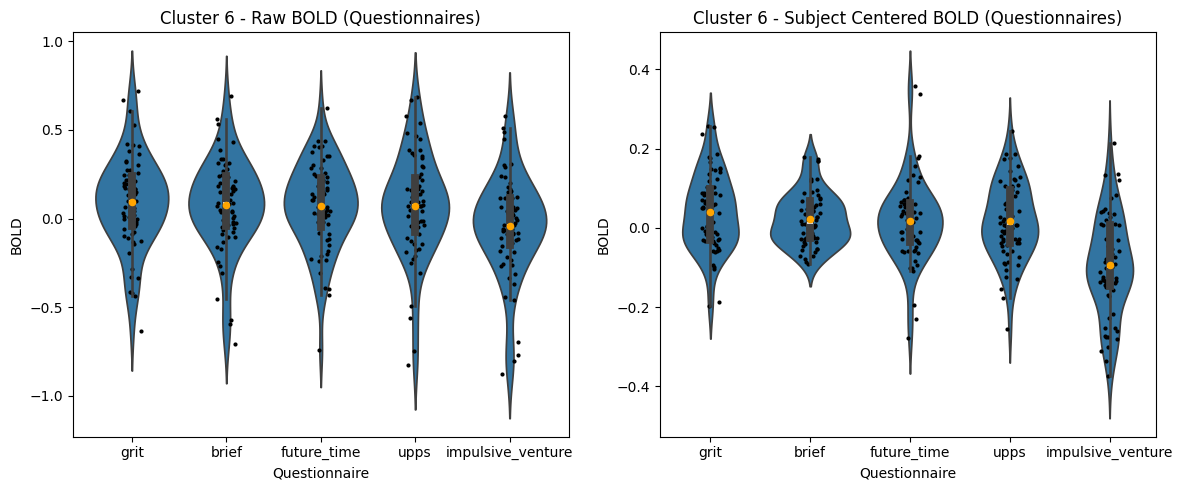

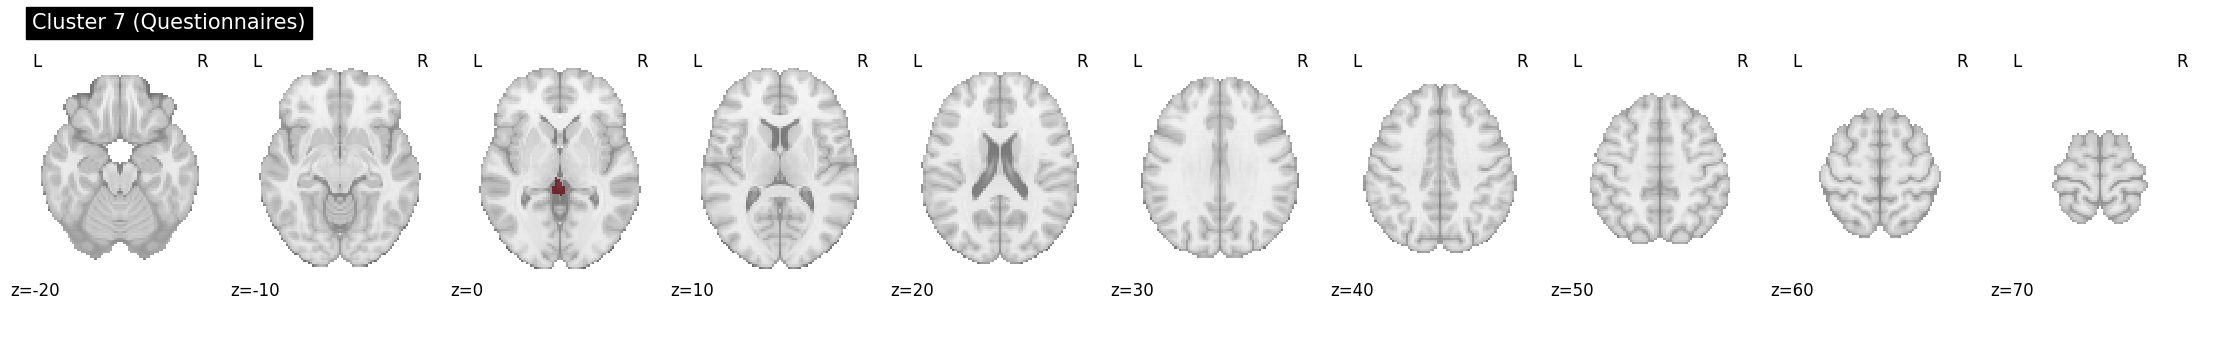

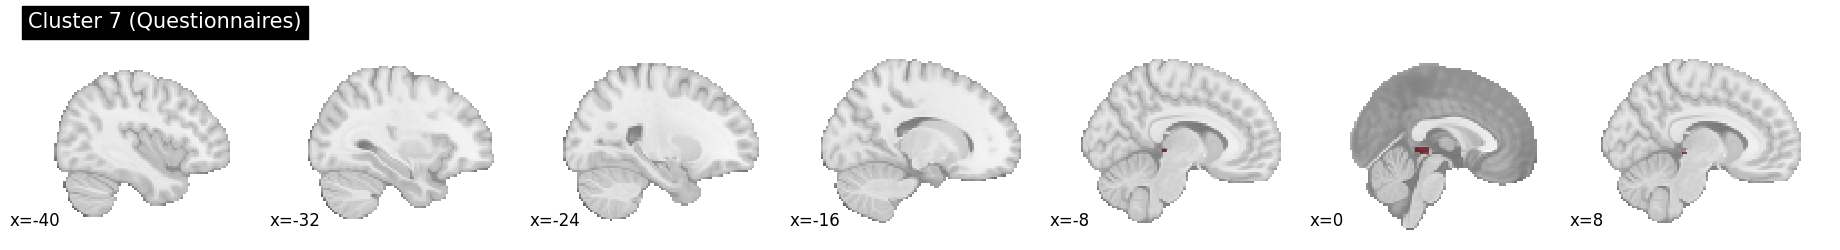

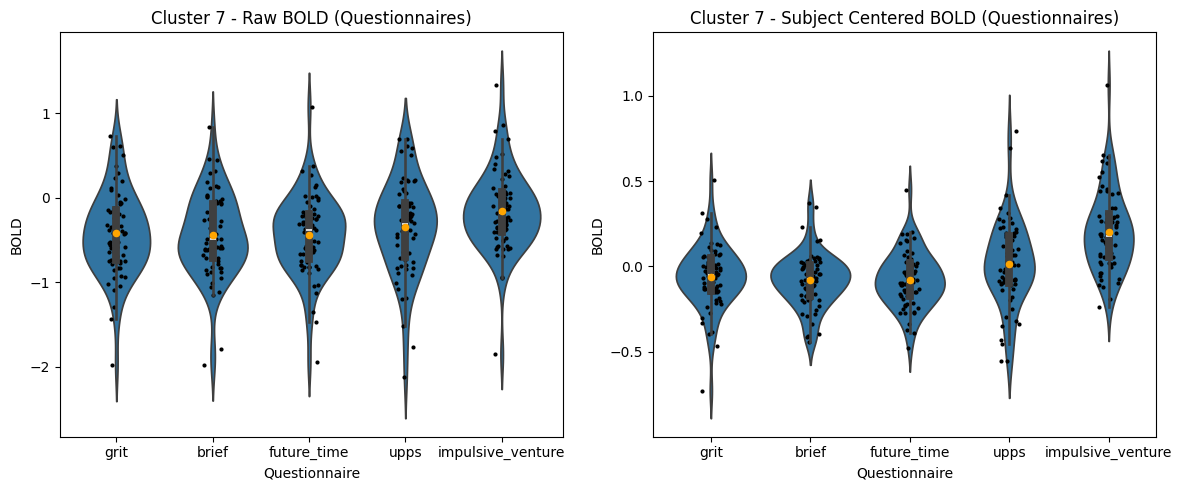

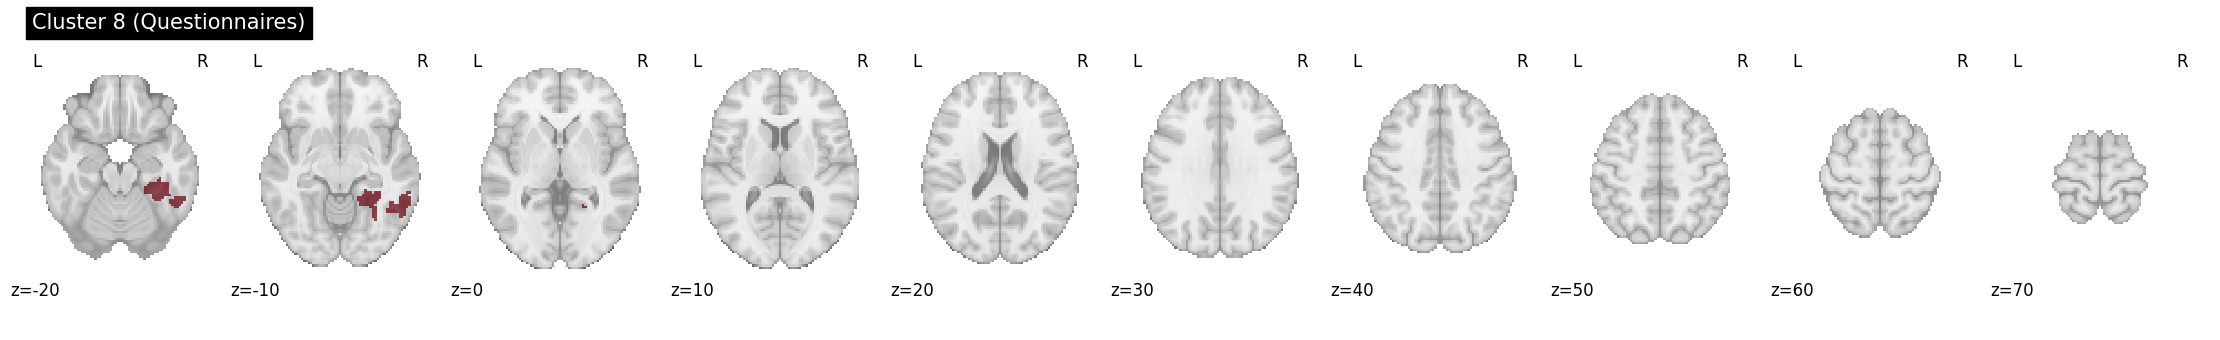

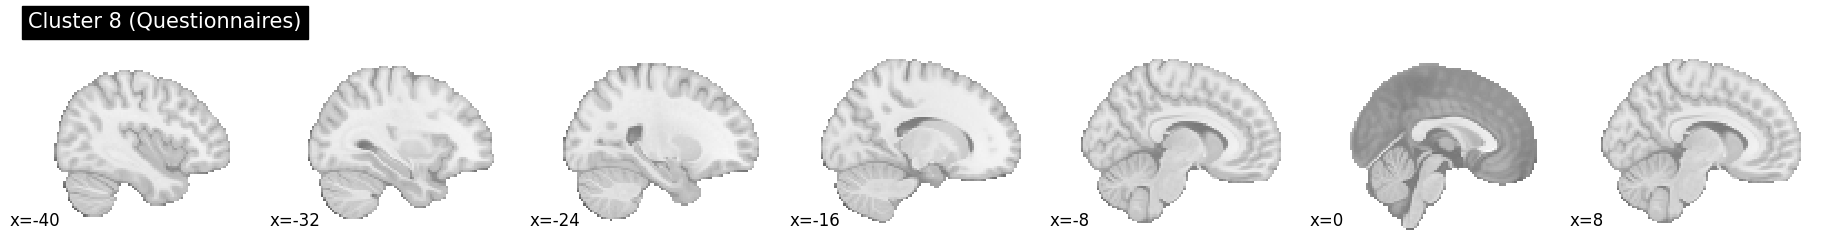

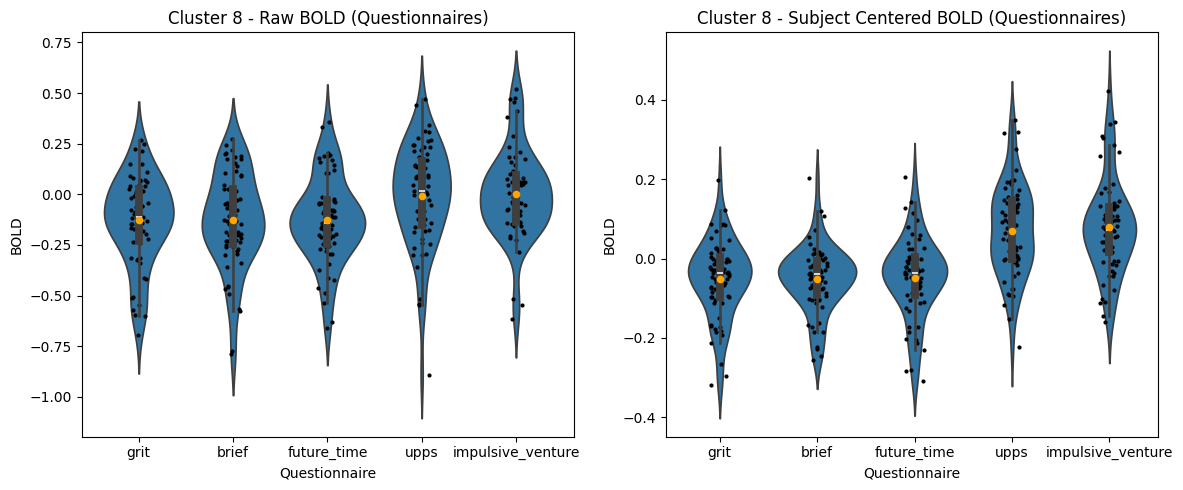

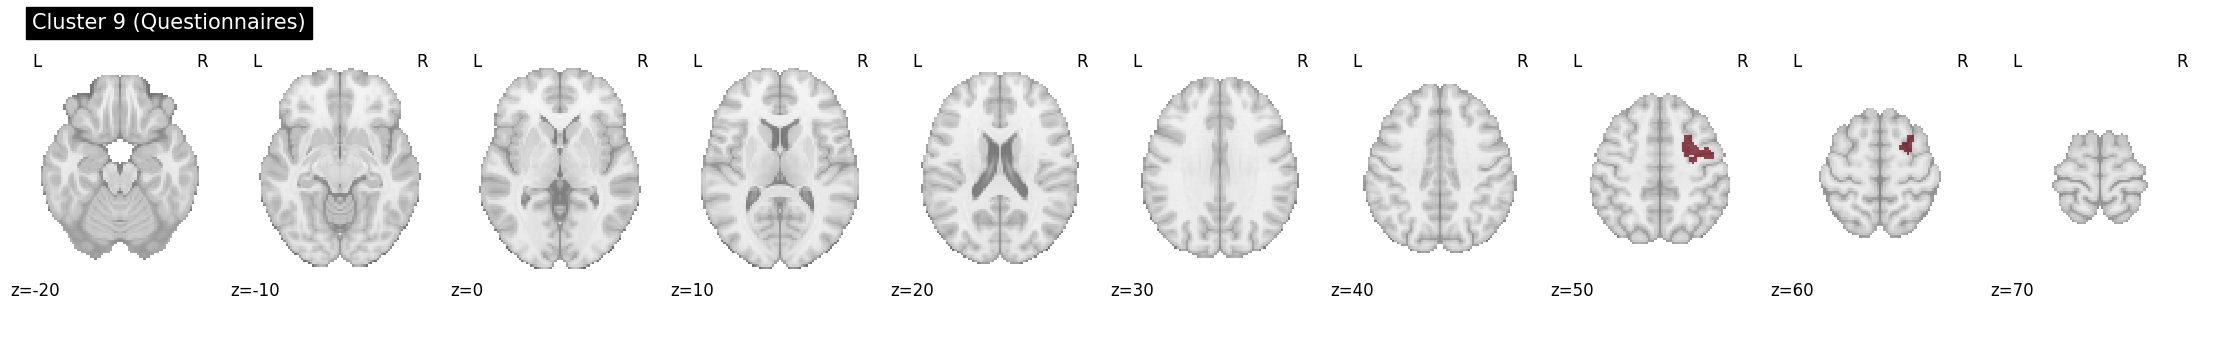

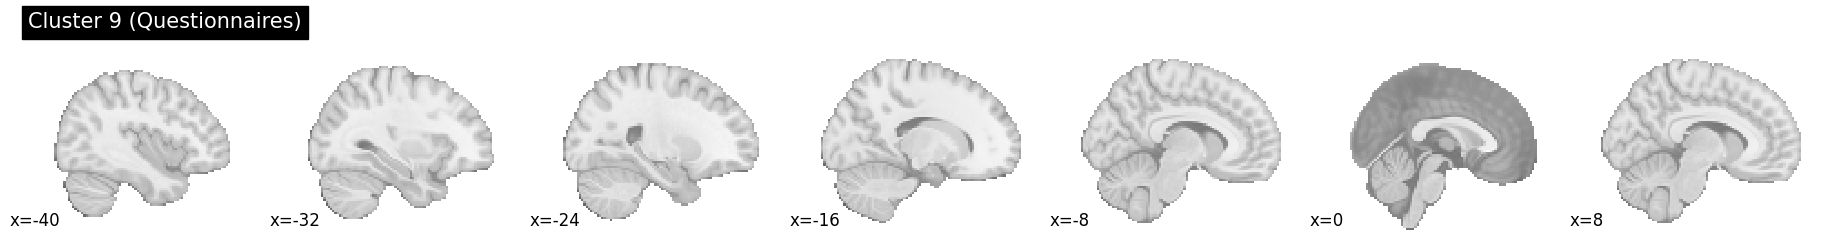

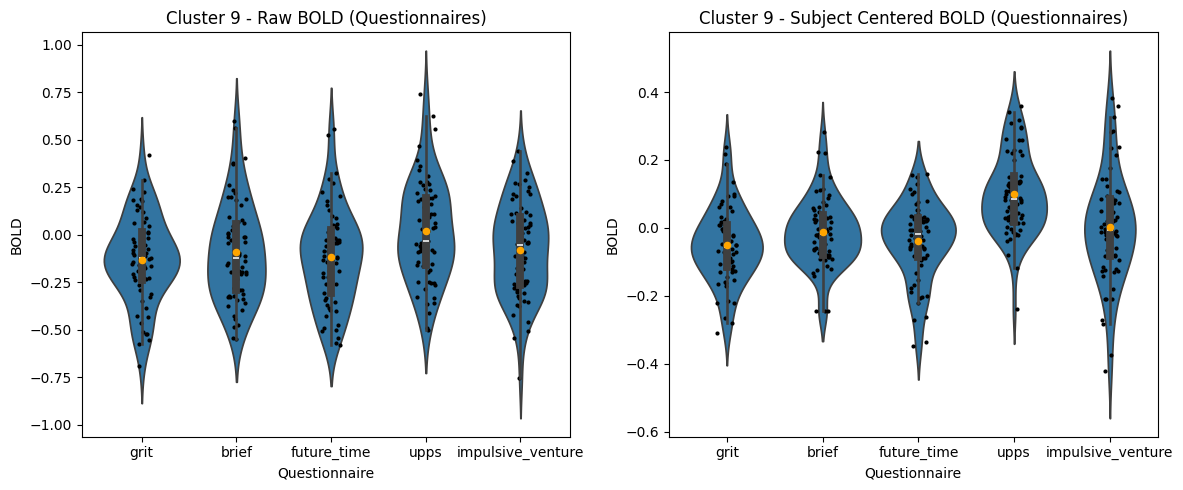

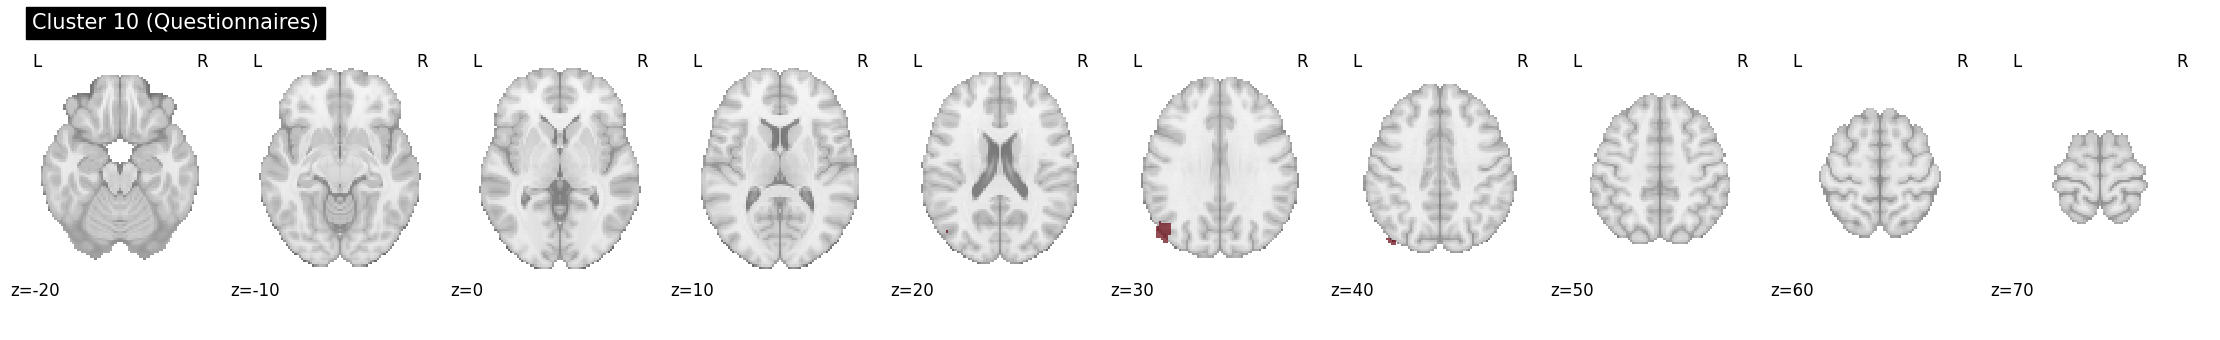

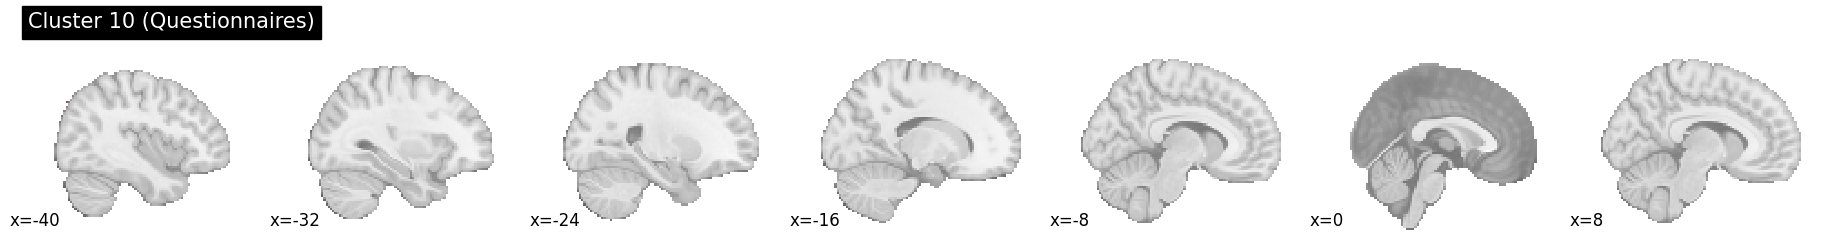

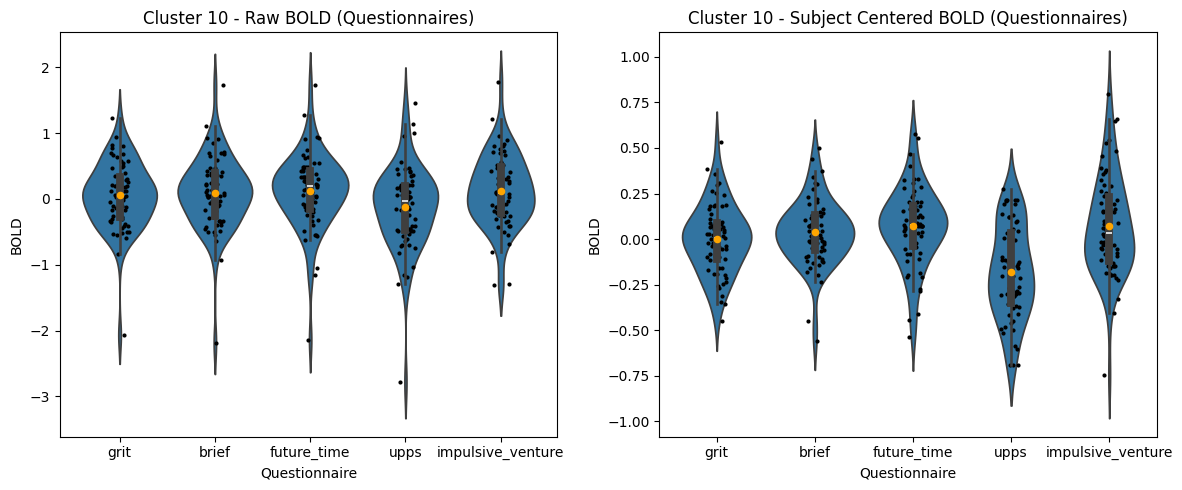

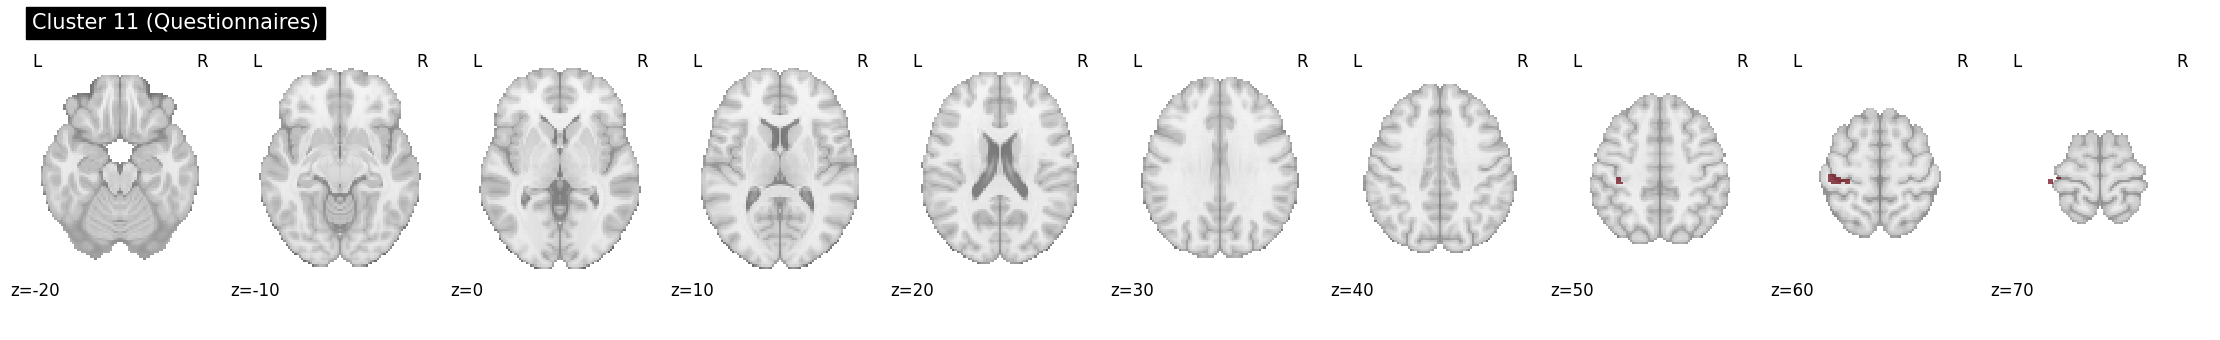

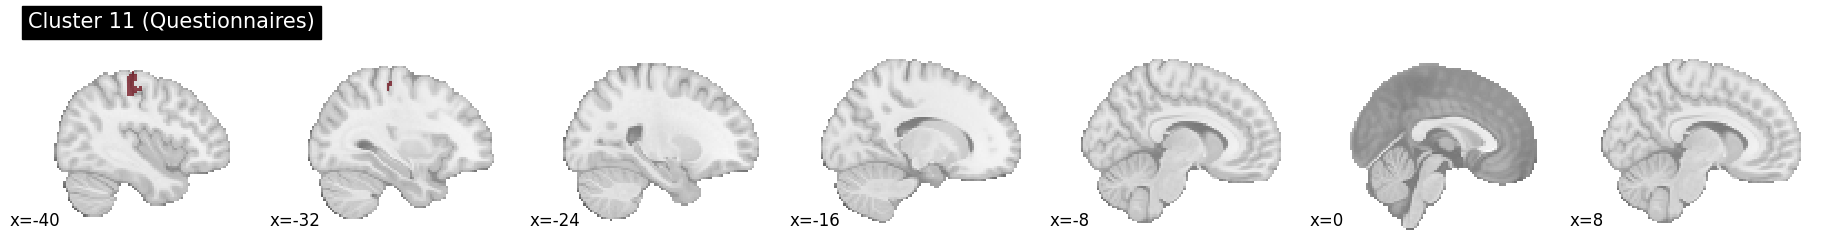

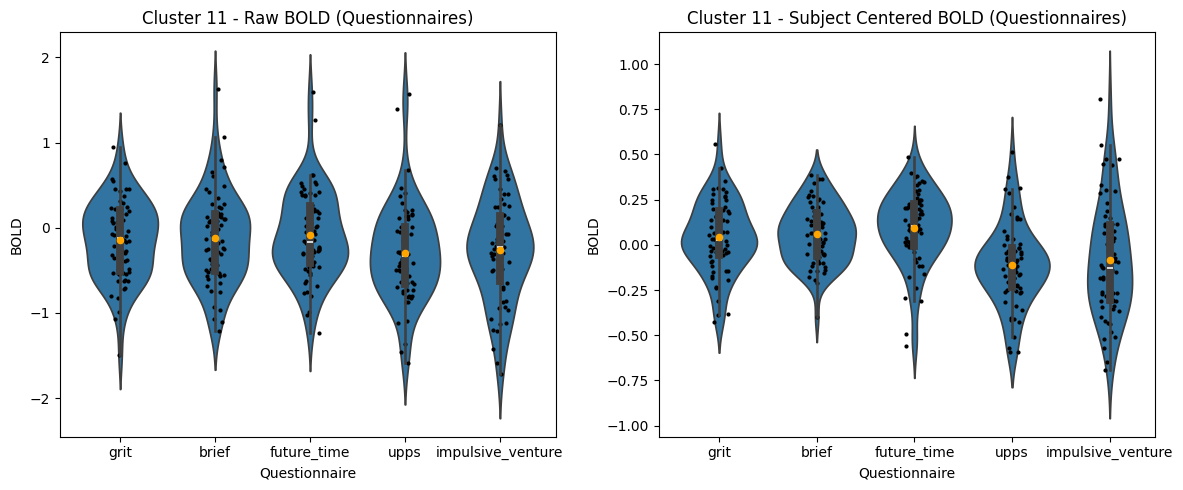

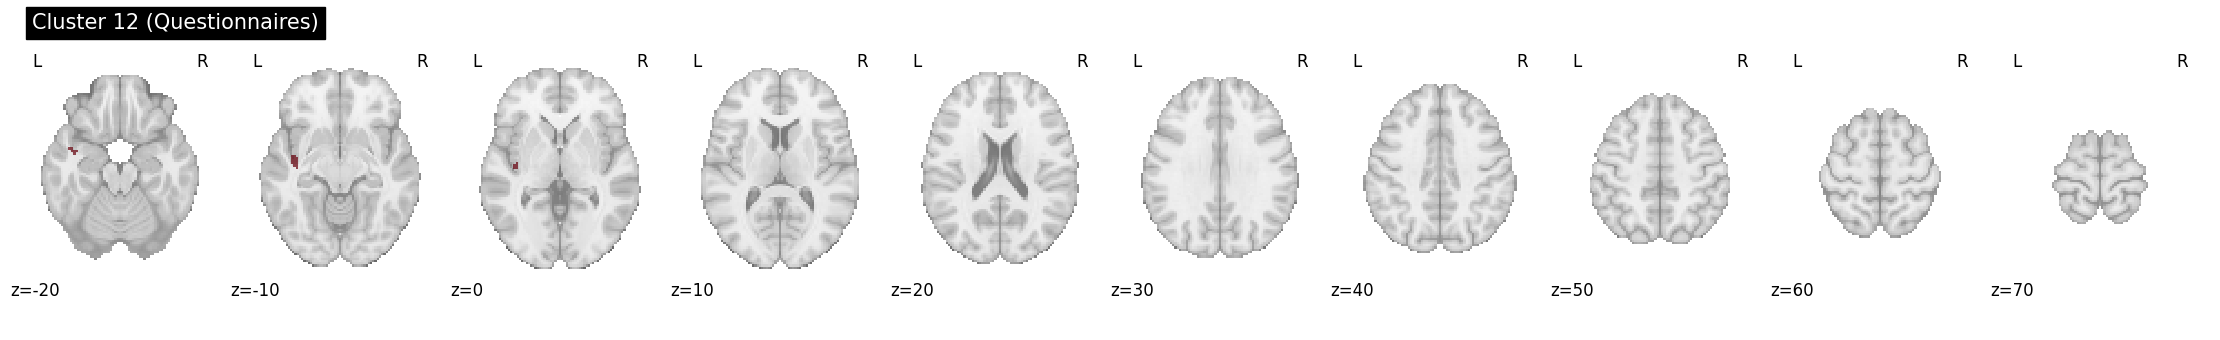

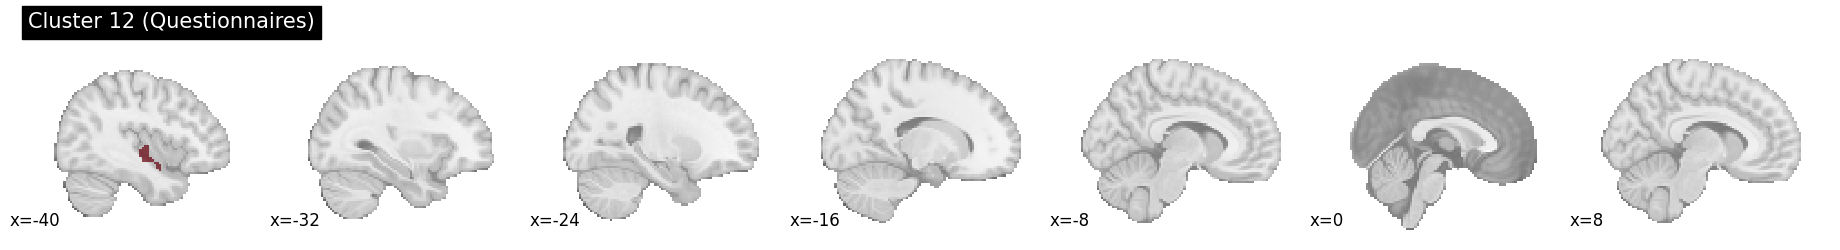

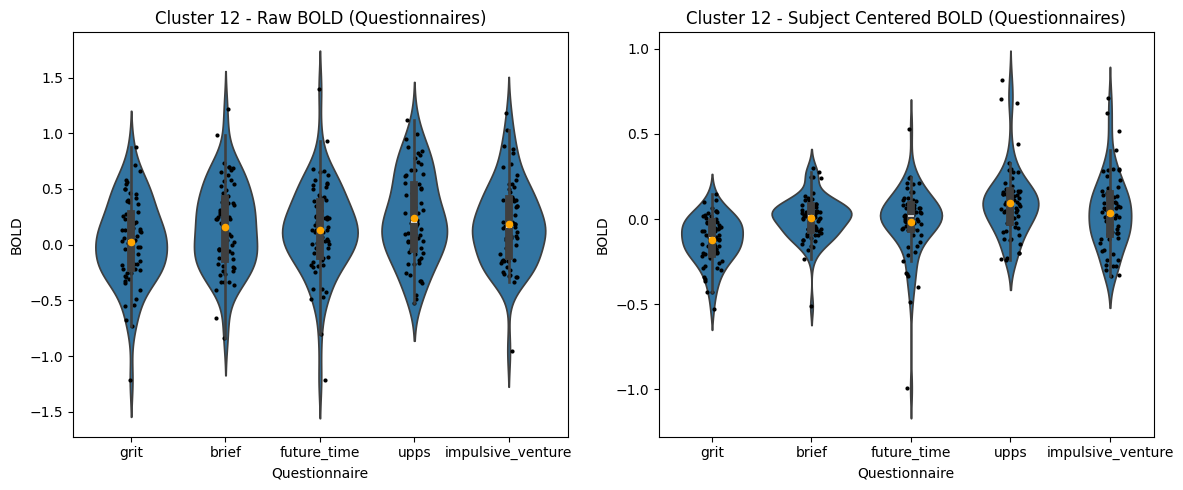

In [6]:
# Step 4: Center within-subject BOLD signals (per cluster)
subject_centered_bold_by_cluster = np.empty_like(bold_by_cluster)
unique_subjects = np.unique(subject_ids)

for subj in unique_subjects:
    idx = np.where(subject_ids == subj)[0]
    subj_data = bold_by_cluster[idx, :]
    subj_mean = subj_data.mean(axis=0, keepdims=True)
    subject_centered_bold_by_cluster[idx, :] = subj_data - subj_mean

# Step 5: Prepare consistent slices for cluster plotting
z_slices = [-20, -10, 0, 10, 20, 30, 40, 50, 60, 70]

# Plotting loop
for cluster_idx, cluster_label in enumerate(cluster_labels):
    # Create nifti image for cluster mask only
    cluster_mask_only = (cluster_data == cluster_label).astype(np.int16)
    cluster_img_only = nib.Nifti1Image(cluster_mask_only, cluster_img.affine)
    # nib.save(cluster_img_only, f"/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/output_surveyMedley_noderivs_rerun/questionnaire_avgs_f_test_output/cluster_{int(cluster_label)}.nii.gz")

    # Plot cluster using nilearn with fixed slices
    display = plotting.plot_roi(
        cluster_img_only,
        title=f'Cluster {int(cluster_label)} (Questionnaires)',
        display_mode='z',
        cut_coords=z_slices,
        cmap='Reds',
        alpha=0.7,
        draw_cross=False, 
        vmin=0.0, 
        vmax=1.0 
    )
    plotting.show()

    # Plot sagittal view
    x_slices = [-40, -32, -24, -16, -8, 0, 8]
    display = plotting.plot_roi(
        cluster_img_only,
        title=f'Cluster {int(cluster_label)} (Questionnaires)',
        display_mode='x',
        cut_coords=x_slices, 
        cmap='Reds', 
        alpha=0.7, 
        vmin=0.0, 
        vmax=1.0
    )
    plotting.show()

    # Create DataFrames for plotting
    df_raw = pd.DataFrame({
        "Questionnaire": questionnaires,
        "BOLD": bold_by_cluster[:, cluster_idx]
    })
    df_raw_mean = df_raw.groupby("Questionnaire")["BOLD"].mean()
    df_raw_mean = df_raw_mean.reset_index()

    df_centered = pd.DataFrame({
        "Questionnaire": questionnaires,
        "BOLD": subject_centered_bold_by_cluster[:, cluster_idx]
    })
    df_centered_mean = df_centered.groupby("Questionnaire")["BOLD"].mean()
    df_centered_mean = df_centered_mean.reset_index()

    # Plot violin plots side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

    sns.violinplot(x="Questionnaire", y="BOLD", data=df_raw, ax=axes[0])
    sns.stripplot(x="Questionnaire", y="BOLD", data=df_raw, color='k', size=3, ax=axes[0], jitter=True, zorder=1)
    df_raw_mean.plot(x="Questionnaire", y="BOLD", kind="scatter", ax=axes[0], color='orange', zorder=10)
    axes[0].set_title(f"Cluster {int(cluster_label)} - Raw BOLD (Questionnaires)")

    sns.violinplot(x="Questionnaire", y="BOLD", data=df_centered, ax=axes[1])
    sns.stripplot(x="Questionnaire", y="BOLD", data=df_centered, color='k', size=3, ax=axes[1], jitter=True, zorder=1)
    df_centered_mean.plot(x="Questionnaire", y="BOLD", kind="scatter", ax=axes[1], color='orange', zorder=10)
    axes[1].set_title(f"Cluster {int(cluster_label)} - Subject Centered BOLD (Questionnaires)")

    plt.tight_layout()
    plt.show()
